# Objective
* 20181225: 
    * Predict stock price in next day using XGBoost
    * Given prices and other features for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)
* 20190110 - Diff from StockPricePrediction_v1_xgboost.ipynb:
    * Here we scale the train set to have mean 0 and variance 1, and apply the same transformation to dev and test sets
* 20190111 - Diff from StockPricePrediction_v1a_xgboost.ipynb:
    * Here for the past N values for the dev set, we scale them to have mean 0 and variance 1, and do prediction on them
* 20190112 - Diff from StockPricePrediction_v1b_xgboost.ipynb:
    * Instead of using the same mean and variance to do scaling for train, dev and test sets, we scale the train set to have mean 0 and var 1, and then whenever we do prediction on dev or test set we scale the previous N values to also have mean 0 and var 1 (ie. use the means and variances of the previous N values to do scaling. We do this for both feature columns and target columns)

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pandas_datareader as dr

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 4                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [2]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

# Load data

In [3]:
#На момент написание курсовой работы данные были ограничены датой 18-04-2020
df = dr.get_data_yahoo('CBOM.ME')

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df.index,format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,high,low,open,close,volume,adj_close,date,month
Date,,,,,,,,
2015-07-01,3.70647,3.59151,3.59448,3.64700,22199552.0,3.579847,2015-07-01,7
2015-07-02,3.76593,3.59151,3.76593,3.61281,27957072.0,3.546287,2015-07-02,7
2015-07-03,3.69160,3.59894,3.69160,3.60439,38557012.0,3.538022,2015-07-03,7
2015-07-06,3.63709,3.60736,3.60786,3.63709,8483465.0,3.570120,2015-07-06,7
2015-07-07,3.76593,3.59844,3.76593,3.59844,30759598.0,3.532182,2015-07-07,7


Text(0, 0.5, 'Цена закрытия CBOM, RUB')

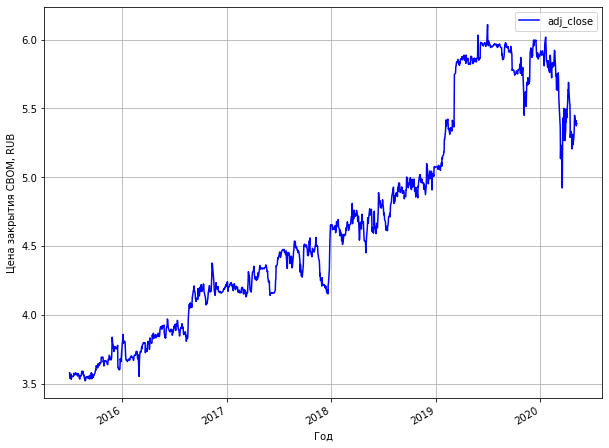

In [4]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("Год")
ax.set_ylabel("Цена закрытия CBOM, RUB")

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [5]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,volume,adj_close,date,month,range_hl,range_oc
Date,,,,,,
2015-07-01,22199552.0,3.579847,2015-07-01,7,0.11496,-0.05252
2015-07-02,27957072.0,3.546287,2015-07-02,7,0.17442,0.15312
2015-07-03,38557012.0,3.538022,2015-07-03,7,0.09266,0.08721
2015-07-06,8483465.0,3.570120,2015-07-06,7,0.02973,-0.02923
2015-07-07,30759598.0,3.532182,2015-07-07,7,0.16749,0.16749


Now we use lags up to N number of days to use as features.

In [6]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [7]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

,volume,adj_close,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_lag_4,range_hl_lag_4,range_oc_lag_4,volume_lag_4
4,30759598.0,3.532182,2015-07-07,7,0.16749,0.16749,4,3.570120,0.02973,-0.02923,...,0.08721,38557012.0,3.546287,0.17442,0.15312,27957072.0,3.579847,0.11496,-0.05252,22199552.0
5,40767635.0,3.549693,2015-07-08,7,0.03914,-0.02824,5,3.532182,0.16749,0.16749,...,-0.02923,8483465.0,3.538022,0.09266,0.08721,38557012.0,3.546287,0.17442,0.15312,27957072.0
6,34994167.0,3.550665,2015-07-09,7,0.02477,-0.02477,6,3.549693,0.03914,-0.02824,...,0.16749,30759598.0,3.570120,0.02973,-0.02923,8483465.0,3.538022,0.09266,0.08721,38557012.0
7,27123497.0,3.550665,2015-07-10,7,0.16650,0.14866,7,3.550665,0.02477,-0.02477,...,-0.02824,40767635.0,3.532182,0.16749,0.16749,30759598.0,3.570120,0.02973,-0.02923,8483465.0
8,36299169.0,3.555043,2015-07-13,7,0.05550,0.04311,8,3.550665,0.16650,0.14866,...,-0.02477,34994167.0,3.549693,0.03914,-0.02824,40767635.0,3.532182,0.16749,0.16749,30759598.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1218 entries, 4 to 1221
Data columns (total 23 columns):
volume             1218 non-null float64
adj_close          1218 non-null float64
date               1218 non-null datetime64[ns]
month              1218 non-null int64
range_hl           1218 non-null float64
range_oc           1218 non-null float64
order_day          1218 non-null int64
adj_close_lag_1    1218 non-null float64
range_hl_lag_1     1218 non-null float64
range_oc_lag_1     1218 non-null float64
volume_lag_1       1218 non-null float64
adj_close_lag_2    1218 non-null float64
range_hl_lag_2     1218 non-null float64
range_oc_lag_2     1218 non-null float64
volume_lag_2       1218 non-null float64
adj_close_lag_3    1218 non-null float64
range_hl_lag_3     1218 non-null float64
range_oc_lag_3     1218 non-null float64
volume_lag_3       1218 non-null float64
adj_close_lag_4    1218 non-null float64
range_hl_lag_4     1218 non-null float64
range_oc_lag_4     1218 non-n

In [9]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [10]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [11]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,volume,adj_close,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_4,volume_lag_4,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
4,30759598.0,3.532182,2015-07-07,7,0.16749,0.16749,4,3.570120,0.02973,-0.02923,...,-0.05252,22199552.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,40767635.0,3.549693,2015-07-08,7,0.03914,-0.02824,5,3.532182,0.16749,0.16749,...,0.15312,27957072.0,3.532182,NaN,0.167490,NaN,0.167490,NaN,3.075960e+07,NaN
6,34994167.0,3.550665,2015-07-09,7,0.02477,-0.02477,6,3.549693,0.03914,-0.02824,...,0.08721,38557012.0,3.540937,0.012383,0.103315,0.090757,0.069625,0.138402,3.576362e+07,7.076751e+06
7,27123497.0,3.550665,2015-07-10,7,0.16650,0.14866,7,3.550665,0.02477,-0.02477,...,-0.02923,8483465.0,3.544180,0.010402,0.077133,0.078580,0.038160,0.112017,3.550713e+07,5.023699e+06
8,36299169.0,3.555043,2015-07-13,7,0.05550,0.04311,8,3.550665,0.16650,0.14866,...,0.16749,30759598.0,3.545801,0.009091,0.099475,0.078187,0.065785,0.106854,3.341122e+07,5.864842e+06


# Split into train, dev and test set

In [12]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 732
num_cv = 243
num_test = 243
train.shape = (732, 31)
cv.shape = (243, 31)
train_cv.shape = (975, 31)
test.shape = (243, 31)


# Scale the train, dev and test set

In [13]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [4.12054550e+00 4.11910676e+00 5.37825885e-02 3.06957178e-03
 8.33454607e+06 4.11758261e+00 5.36946925e-02 2.99882075e-03
 8.38148659e+06 4.11593430e+00 5.37581079e-02 3.31592462e-03
 8.34345677e+06 4.11446863e+00 5.37785451e-02 3.27559638e-03
 8.36100547e+06]
scaler.var_ = [1.26159901e-01 1.26226454e-01 3.19351037e-03 1.33548973e-03
 1.01923591e+15 1.26294986e-01 3.18101305e-03 1.31991447e-03
 1.02045813e+15 1.26186835e-01 3.19337696e-03 1.34141580e-03
 1.01790910e+15 1.26183660e-01 3.19557239e-03 1.34472720e-03
 1.01816968e+15]
train_scaled.shape = (732, 17)
train_scaled.shape = (732, 19)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_lag_4,range_hl_lag_4,range_oc_lag_4,volume_lag_4,date,month
0,-1.656477,-1.545207,-0.425624,-0.883842,0.004665,-1.630820,0.690872,2.317916,0.944620,-1.603611,2.135230,4.090176,0.614757,-1.505028,1.082294,-1.521539,0.433691,2015-07-07,7
1,-1.607175,-1.651991,2.012123,4.499202,0.702419,-1.540499,-0.424901,-0.887095,0.003192,-1.626878,0.688411,2.290607,0.946994,-1.599506,2.134135,4.086237,0.614128,2015-07-08,7
2,-1.604440,-1.602702,-0.259110,-0.856754,1.015900,-1.647254,2.017631,4.527618,0.700529,-1.536519,-0.425200,-0.888614,0.004388,-1.622773,0.687813,2.288884,0.946323,2015-07-09,7
3,-1.604440,-1.599967,-0.513395,-0.761803,0.835058,-1.597978,-0.258060,-0.859847,1.013822,-1.643319,2.012599,4.482527,0.702597,-1.532413,-0.425415,-0.886420,0.003838,2015-07-10,7
4,-1.592114,-1.599967,1.994602,3.983936,0.588525,-1.595244,-0.512845,-0.764337,0.833088,-1.594022,-0.258682,-0.861586,1.016283,-1.639214,2.011546,4.478104,0.701957,2015-07-13,7


In [14]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [4.37825953e+00 4.37590986e+00 5.80716380e-02 1.73223911e-03
 7.67381053e+06 4.37353833e+00 5.81389818e-02 1.81655713e-03
 7.70906870e+06 4.37118535e+00 5.82645406e-02 1.99924396e-03
 7.73395800e+06 4.36886579e+00 5.82409098e-02 2.06435179e-03
 7.75251416e+06]
scaler_train_cv.var_ = [3.34566535e-01 3.32975790e-01 3.63188857e-03 1.65790941e-03
 7.68443236e+14 3.31460786e-01 3.63212087e-03 1.66538517e-03
 7.69407703e+14 3.29950162e-01 3.64593440e-03 1.68809399e-03
 7.69811010e+14 3.28370028e-01 3.64270987e-03 1.67685743e-03
 7.70011795e+14]
train_cv_scaled.shape = (975, 17)
train_cv_scaled.shape = (975, 19)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_lag_4,range_hl_lag_4,range_oc_lag_4,volume_lag_4,date,month
0,-1.462747,-1.396418,-0.470281,-0.760414,0.029207,-1.451239,0.572804,2.092513,1.112111,-1.436072,1.923689,3.678120,0.728880,-1.376910,0.939759,-1.332970,0.520631,2015-07-07,7
1,-1.432472,-1.462165,1.815616,4.070929,0.832796,-1.395487,-0.471383,-0.760772,0.027918,-1.450461,0.569638,2.073944,1.110922,-1.435476,1.924931,3.688833,0.728116,2015-07-08,7
2,-1.430792,-1.431817,-0.314139,-0.736102,1.193826,-1.461383,1.814440,4.059715,0.831003,-1.394581,-0.472569,-0.760084,0.027014,-1.449899,0.570282,2.079291,1.110109,2015-07-09,7
3,-1.430792,-1.430134,-0.552585,-0.650882,0.985554,-1.430967,-0.315247,-0.736515,1.191807,-1.460629,1.808920,4.027870,0.829888,-1.393885,-0.472387,-0.764216,0.026341,2015-07-10,7
4,-1.423223,-1.430134,1.799186,3.608472,0.701628,-1.429279,-0.553685,-0.651486,0.983665,-1.430142,-0.316728,-0.735990,1.190597,-1.460091,1.810112,4.039753,0.829111,2015-07-13,7


In [15]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_hl_lag_4,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,range_oc_lag_4,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4
736,2018-06-05,-0.836853,-0.299182,1.452574,-0.316538,-0.819007,1.305021,0.260997,-0.747012,0.222001,1.281188,-1.051164,-0.452025,-0.221287,-0.732638,1.466732,-0.512807
737,2018-06-06,-0.549040,-0.714161,-0.202274,1.465474,-0.661386,-0.884955,1.313466,0.232876,-0.459302,0.224311,1.281780,-1.046789,-0.322579,-0.300079,-0.831484,1.454142
738,2018-06-07,-1.318730,0.304316,-0.064554,1.078969,-0.853147,-0.201654,-0.387797,1.442598,0.059602,-1.147421,-0.193721,1.281540,0.001296,0.660330,0.752028,-1.413654
739,2018-06-08,-0.079549,-1.352127,0.980958,0.450717,-1.353660,-0.134143,0.890244,0.597559,-0.301937,1.018166,-1.256914,0.540684,-0.996317,-0.718436,0.754879,0.959875
740,2018-06-11,1.250692,-0.375980,-1.112577,0.237865,0.765926,-1.337516,-0.194337,0.765926,-1.150132,0.299617,1.208117,-0.357603,-1.078305,-0.252408,-0.001033,1.331746


In [16]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_hl_lag_4,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,range_oc_lag_4,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4
979,2019-05-23,1.331435,0.204843,-0.819359,-0.716919,-0.784394,-0.551317,-0.103091,1.438801,0.690267,0.638501,0.120803,-1.449571,0.384221,0.712259,-1.482030,0.385550
980,2019-05-24,-0.920562,1.288804,0.276176,-0.644419,0.411617,-1.173874,-0.381129,1.143386,0.864077,0.370304,0.205730,-1.440111,-0.524655,0.671936,0.989937,-1.137218
981,2019-05-27,0.898135,-1.306397,0.653209,-0.244946,0.528976,0.969736,-1.322387,-0.176325,-1.264909,1.159508,0.210801,-0.105401,0.039231,-1.398506,0.435887,0.923388
982,2019-05-28,0.667117,0.518869,-1.482501,0.296515,-0.365887,0.581144,1.011575,-1.226831,-0.475990,-1.077243,1.227568,0.325665,-1.033264,0.663638,-0.658881,1.028507
983,2019-05-29,1.483948,-0.380642,-0.402708,-0.700598,1.493667,-0.621503,-0.470417,-0.401747,-1.489356,0.451689,0.378442,0.659225,1.488943,-0.611269,-0.328738,-0.548935


# Split into X and y

In [17]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (732, 16)
y_train.shape = (732,)
X_cv.shape = (243, 16)
y_cv.shape = (243,)
X_train_cv.shape = (975, 16)
y_train_cv.shape = (975,)
X_sample.shape = (243, 16)
y_sample.shape = (243,)


In [18]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (732, 16)
y_train_scaled.shape = (732,)
X_cv_scaled.shape = (243, 16)
X_train_cv_scaled.shape = (975, 16)
y_train_cv_scaled.shape = (975,)
X_sample_scaled.shape = (243, 16)


# EDA

Text(0.5, 1.0, 'Разделённая выборка')

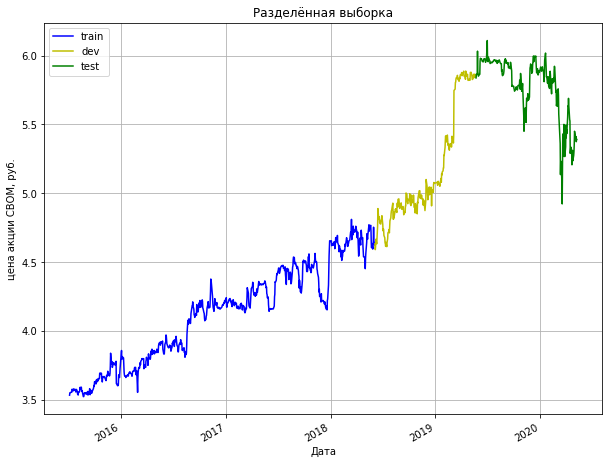

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("Дата")
ax.set_ylabel("цена акции CBOM, руб.")
ax.set_title("Разделённая выборка")

Text(0.5, 1.0, 'With scaling')

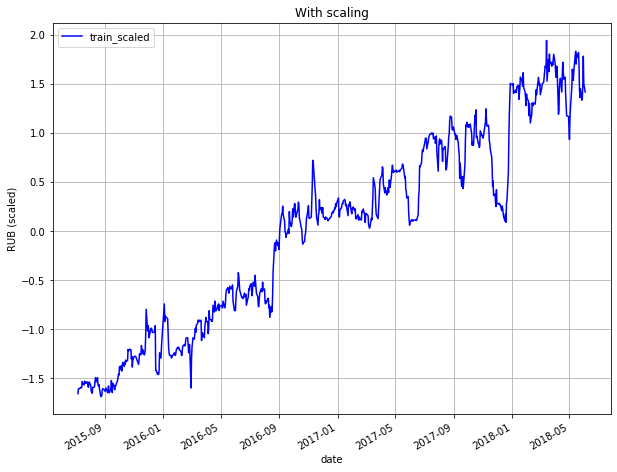

In [20]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("RUB (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [21]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=100, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

# Predict on train set

In [22]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.021
MAPE on train set = 0.366%


Text(0.5, 1.0, 'Нанесли на график тестовой части выборки предсказанные моделью значения')

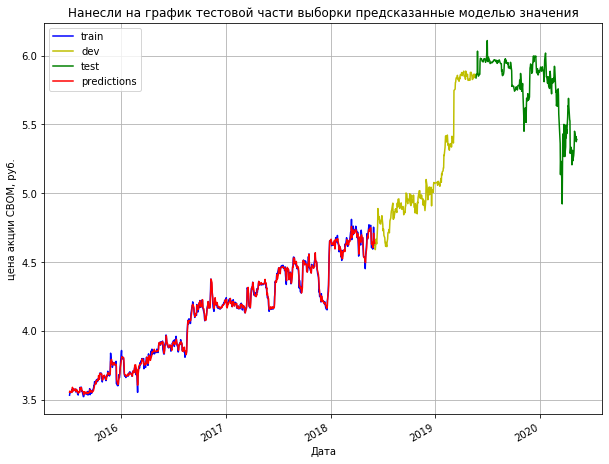

In [23]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("Дата")
ax.set_ylabel("цена акции CBOM, руб.")
ax.set_title('Нанесли на график тестовой части выборки предсказанные моделью значения')

# Predict on dev set

In [24]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

C:\Users\2\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\2\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


RMSE on dev set = 0.041
MAPE on dev set = 0.530%


Text(0, 0.5, 'USD')

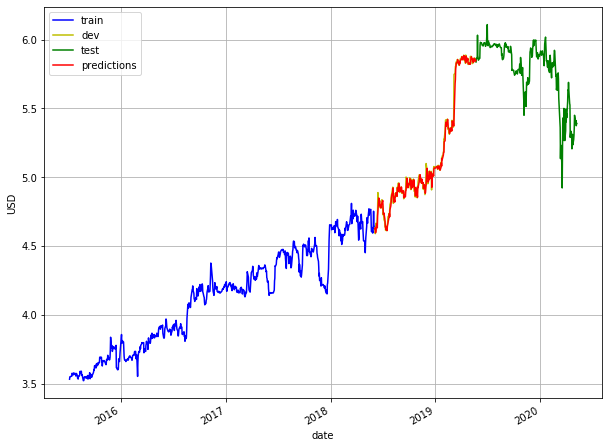

In [25]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Демонстрация результатов модели на второй части тестовой подвыборки (dev)')

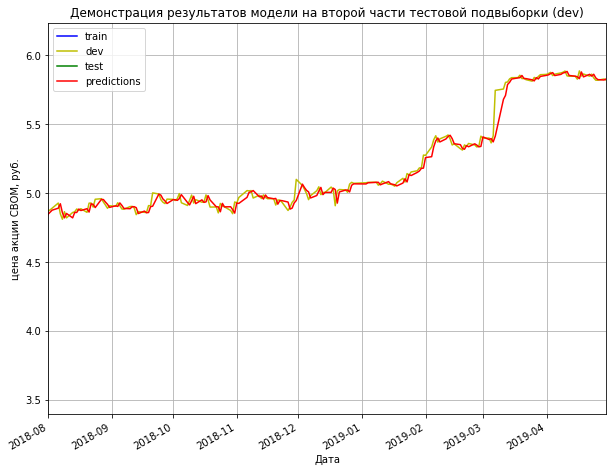

In [26]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("Дата")
ax.set_ylabel("цена акции CBOM, руб.")
ax.set_xlim([date(2018, 8, 1), date(2019, 4, 30)])
ax.set_title("Демонстрация результатов модели на второй части тестовой подвыборки (dev)")

The predictions capture the turn in directions with a slight lag

In [27]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('volume_lag_1', 0.0012479997),
 ('range_oc_lag_1', 0.0012523347),
 ('range_hl_lag_4', 0.001420777),
 ('range_hl_lag_2', 0.0015159718),
 ('volume_lag_4', 0.0015505503),
 ('volume_lag_3', 0.0018074857),
 ('adj_close_lag_4', 0.002943737),
 ('adj_close_lag_2', 0.032074608),
 ('adj_close_lag_3', 0.3739179),
 ('adj_close_lag_1', 0.57699454)]

Importance features dominated by adj_close and volume

# Tuning N (no. of days to use as features)

In [28]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [0.043, 0.043, 0.042, 0.043, 0.043, 0.044, 0.052],
     'mape_pct_dev_set': [0.571, 0.572, 0.560, 0.570, 0.579, 0.591, 0.682]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,0.043,0.571
1,3,0.043,0.572
2,4,0.042,0.560
3,5,0.043,0.570
4,6,0.043,0.579
5,7,0.044,0.591
6,14,0.052,0.682


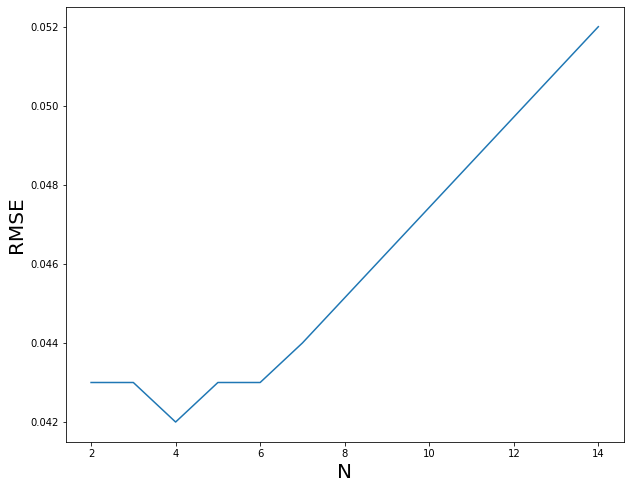

In [29]:
y= [2,3,4,5,6,7,14]
plt.xlabel('N', fontsize=20)  
plt.ylabel('RMSE', fontsize=20)
plt.plot(y, d["rmse_dev_set"])

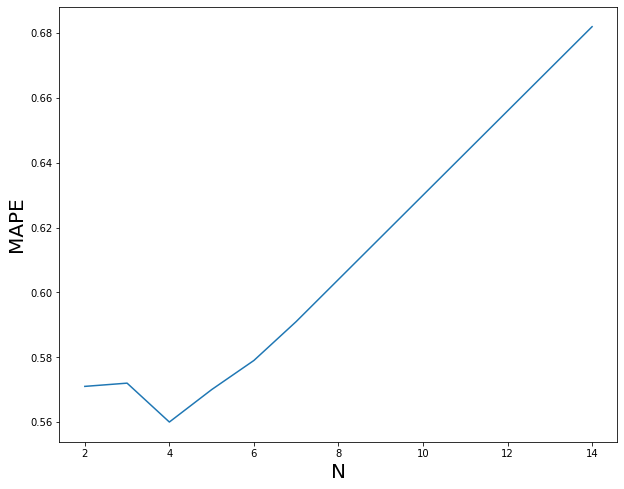

In [30]:
y= [2,3,4,5,6,7,14]
plt.xlabel('N', fontsize=20)  
plt.ylabel('MAPE', fontsize=20)
plt.plot(y, d["mape_pct_dev_set"])

Use N = 4 for lowest RMSE and MAPE

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [31]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 0.8508588671684265


,n_estimators,max_depth,rmse,mape_pct
0,10,2,0.042556,0.558772
1,10,3,0.042041,0.552228
2,10,4,0.042012,0.550442
3,10,5,0.043102,0.564520
4,10,6,0.043116,0.564860
5,10,7,0.043101,0.564186
6,10,8,0.043197,0.565184
7,10,9,0.043176,0.564354
8,20,2,0.041128,0.537029
9,20,3,0.040838,0.533633


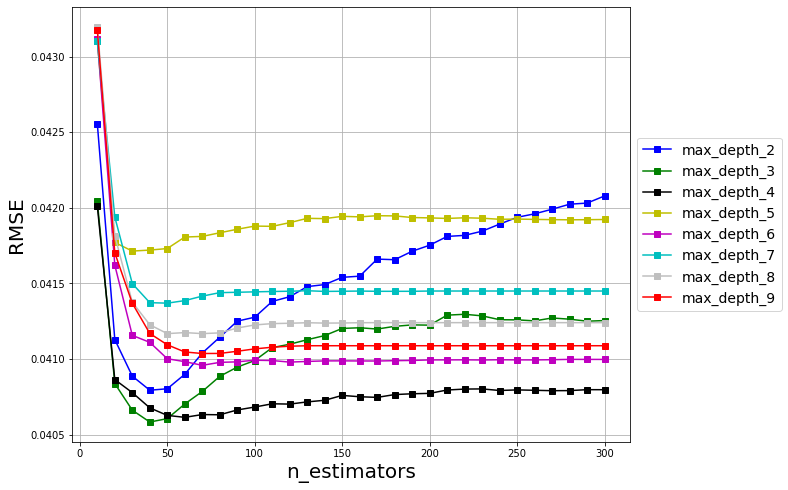

In [32]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label, fontsize = 20)
ax.set_ylabel("RMSE", fontsize = 20)
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [33]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.041
optimum params = 


(40, 3)

In [34]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 0.527%
optimum params = 


(50, 3)

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [35]:
param_label = 'learning_rate'
param_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4]

param2_label = 'min_child_weight'
param2_list = range(1, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 0.14894355138142903


,learning_rate,min_child_weight,rmse,mape_pct
0,0.0001,1,0.049216,0.668077
1,0.0001,2,0.049216,0.668077
2,0.0001,3,0.049216,0.668077
3,0.0001,4,0.049216,0.668077
4,0.0001,5,0.049216,0.668077
5,0.0001,6,0.049216,0.668077
6,0.0001,7,0.049216,0.668077
7,0.0001,8,0.049216,0.668077
8,0.0001,9,0.049216,0.668077
9,0.0001,10,0.049216,0.668077


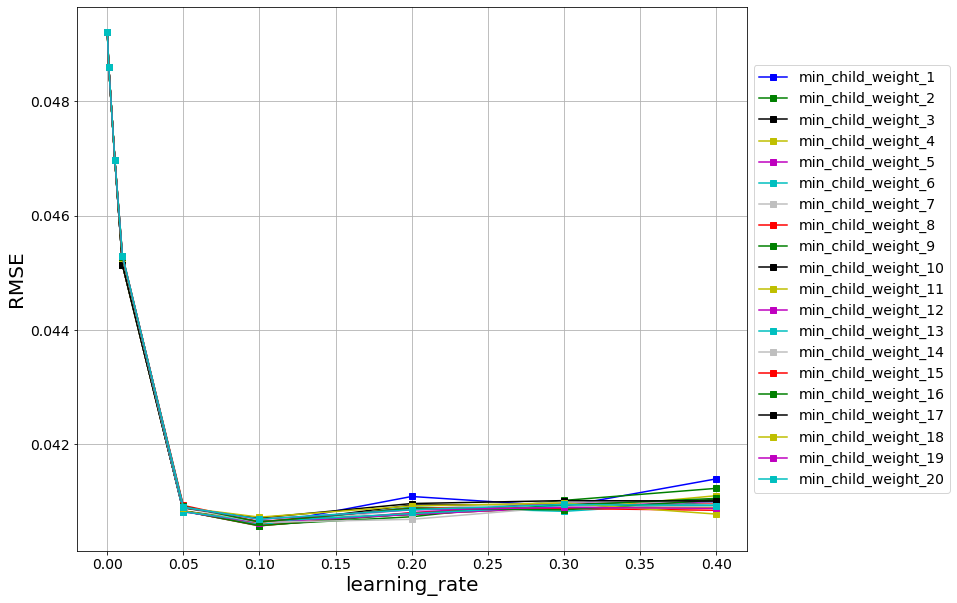

In [36]:
# Plot performance versus params
rcParams['figure.figsize'] = 12, 10 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label, fontsize = 20)
ax.set_ylabel("RMSE", fontsize = 20)
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [37]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 0.041
optimum params = 


(0.1, 7)

In [38]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 0.527%
optimum params = 


(0.1, 7)

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [39]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 0.07144810756047566


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,0.041075,0.533381
1,0.1,0.2,0.041224,0.535891
2,0.1,0.3,0.041137,0.535507
3,0.1,0.4,0.041816,0.543556
4,0.1,0.5,0.041864,0.543999
5,0.1,0.6,0.041608,0.541312
6,0.1,0.7,0.042090,0.545842
7,0.1,0.8,0.042034,0.544868
8,0.1,0.9,0.041956,0.543016
9,0.1,1.0,0.041863,0.542363


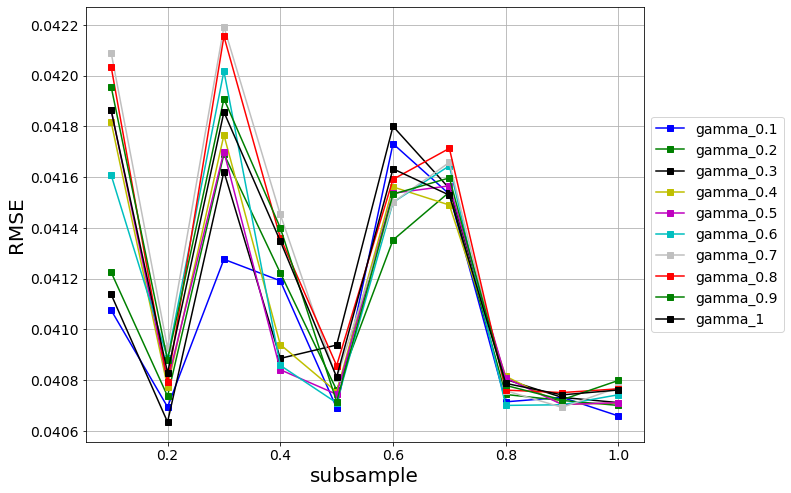

In [40]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label, fontsize = 20)
ax.set_ylabel("RMSE", fontsize = 20)
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [41]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 0.041
optimum params = 


(0.2, 0.3)

In [42]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 0.528%
optimum params = 


(1.0, 0.1)

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [43]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 0.019723697503407796


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,0.053236,0.671588
1,0.5,0.6,0.053236,0.671588
2,0.5,0.7,0.049942,0.643505
3,0.5,0.8,0.049602,0.638390
4,0.5,0.9,0.049090,0.632581
5,0.5,1.0,0.047882,0.621985
6,0.6,0.5,0.052759,0.666951
7,0.6,0.6,0.049856,0.638067
8,0.6,0.7,0.049949,0.637265
9,0.6,0.8,0.048187,0.618768


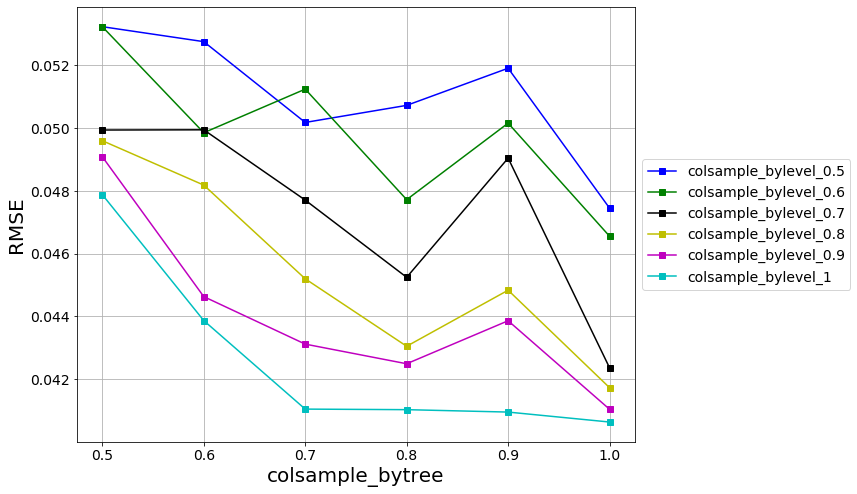

In [44]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label, fontsize = 20)
ax.set_ylabel("RMSE", fontsize = 20)
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [45]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 0.041
optimum params = 


(1.0, 1.0)

In [46]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 0.529%
optimum params = 


(1.0, 1.0)

# Tuned params

In [47]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(5)
tuned_params

,param,original,after_tuning
0,n_estimators,100.00000,40.00000
1,max_depth,3.00000,3.00000
2,learning_rate,0.10000,0.10000
3,min_child_weight,1.00000,7.00000
4,subsample,1.00000,0.20000
5,colsample_bytree,1.00000,1.00000
6,colsample_bylevel,1.00000,1.00000
7,gamma,0.00000,0.30000
8,rmse,0.04099,0.04063
9,mape_pct,0.53004,0.52917


# Final model

In [48]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 0.066
MAPE on test set = 0.719%


Text(0, 0.5, 'USD')

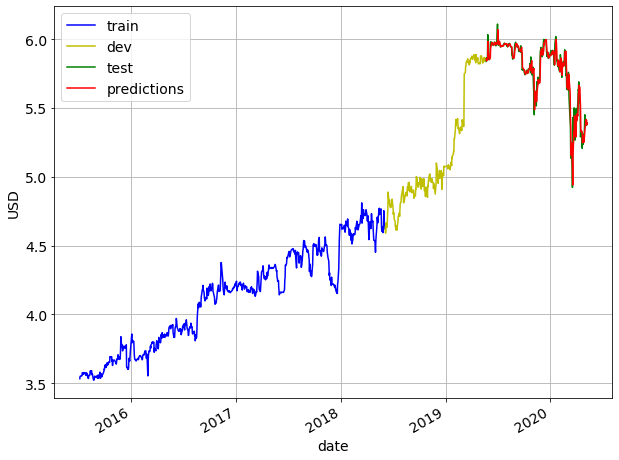

In [49]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Демонстрация результатов модели на тестовой подвыборке (test)')

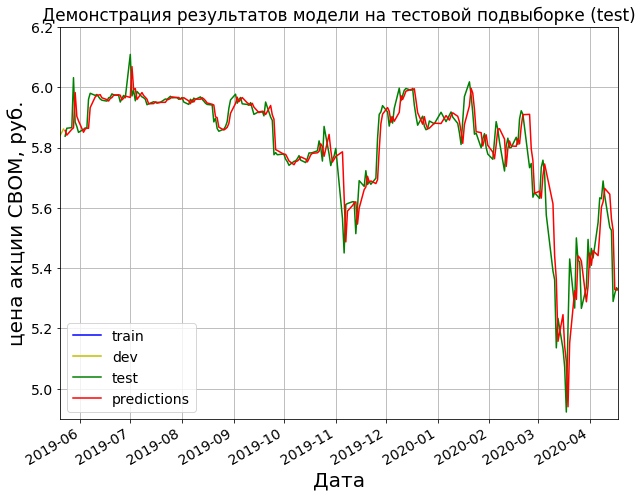

In [61]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("Дата", fontsize = 20)
ax.set_ylabel("цена акции CBOM, руб.", fontsize = 20)
ax.set_xlim([date(2019, 5, 20), date(2020, 4, 18)])
ax.set_ylim([4.9, 6.2])
ax.set_title("Демонстрация результатов модели на тестовой подвыборке (test)")

Similar to dev set, the predictions capture turns in direction with a slight lag

Text(0, 0.5, 'Цена, руб')

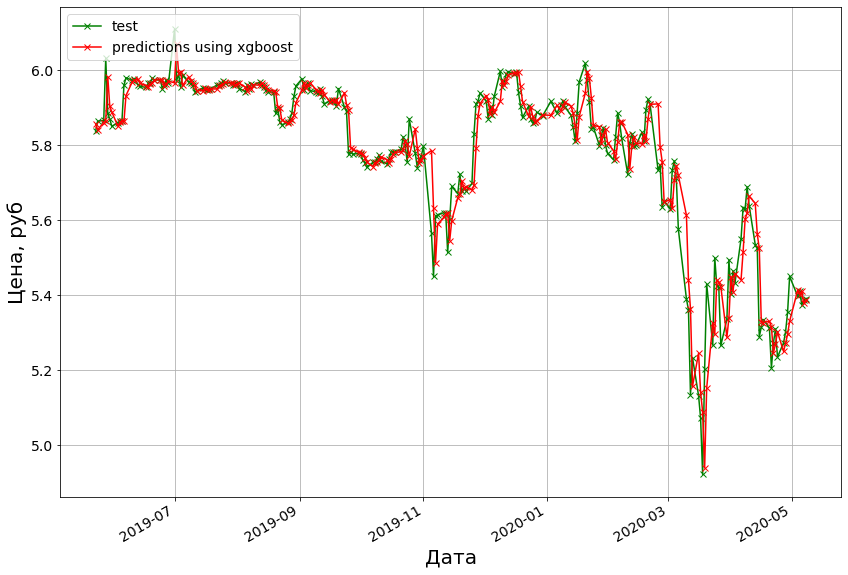

In [51]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 14, 10 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("Дата", fontsize = 20)
ax.set_ylabel("Цена, руб", fontsize = 20)
#ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
#ax.set_ylim([130, 155])

In [52]:
# Save as csv
test_xgboost = est_df
#test_xgboost.to_csv("test_xgboost.csv")

# Findings
* By scaling the features properly, we can get good results for our predictions
* RMSE and MAPE changed very little with hyperparameter tuning
* The final RMSE and MAPE for test set are 1.162 and 0.58% respectively

In [53]:
test_xgboost

,est,y_sample,date
979,5.856881,5.837497,2019-05-23
980,5.841044,5.864000,2019-05-24
981,5.860512,5.865963,2019-05-27
982,5.865129,6.031851,2019-05-28
983,5.982618,5.884613,2019-05-29
984,5.903505,5.869890,2019-05-30
985,5.888731,5.850258,2019-05-31
986,5.850627,5.860074,2019-06-03
987,5.861026,5.864982,2019-06-04
988,5.864295,5.864000,2019-06-05


Text(0.5, 1.0, 'Сравнение ошибки модели и абсолютных значений цен акций')

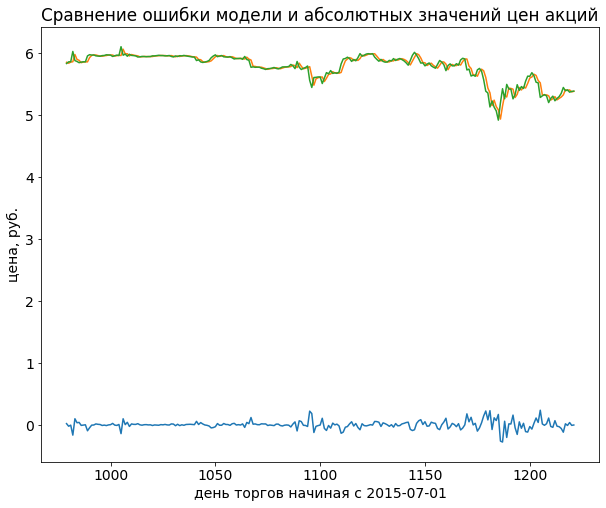

In [54]:
rcParams['figure.figsize'] = 10, 8
plt.plot(test_xgboost.est - test_xgboost.y_sample)
plt.plot(test_xgboost.est)
plt.plot(test_xgboost.y_sample)
plt.xlabel("день торгов начиная с 2015-07-01")
plt.ylabel("цена, руб.")
plt.title("Сравнение ошибки модели и абсолютных значений цен акций")

Text(0.5, 1.0, 'Ошибка модели')

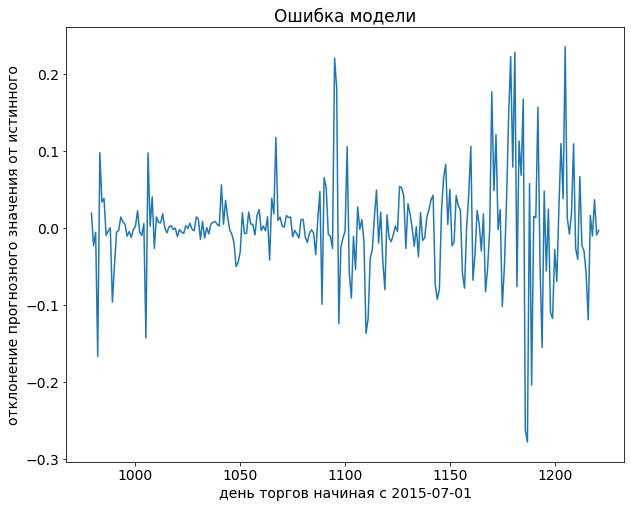

In [55]:
plt.plot(test_xgboost.est - test_xgboost.y_sample)
plt.xlabel("день торгов начиная с 2015-07-01")
plt.ylabel("отклонение прогнозного значения от истинного")
plt.title("Ошибка модели")

In [56]:
pnl_data = test_xgboost

In [57]:
pnl_data

,est,y_sample,date
979,5.856881,5.837497,2019-05-23
980,5.841044,5.864000,2019-05-24
981,5.860512,5.865963,2019-05-27
982,5.865129,6.031851,2019-05-28
983,5.982618,5.884613,2019-05-29
984,5.903505,5.869890,2019-05-30
985,5.888731,5.850258,2019-05-31
986,5.850627,5.860074,2019-06-03
987,5.861026,5.864982,2019-06-04
988,5.864295,5.864000,2019-06-05


In [58]:
pnl_data["position"] = ""

In [59]:
import warnings
warnings.filterwarnings("ignore")

In [60]:
for i in range(0,len(pnl_data)):
    if pnl_data.iloc[i+1,0] > pnl_data.iloc[i,0]:
        pnl_data.iloc[i,3] = 1
    else:
        pnl_data.iloc[i,3] = -1

IndexError: single positional indexer is out-of-bounds

In [ ]:
pnl_data["expected difference in prices"] = pnl_data.shift(-1, axis = 0)["est"] - pnl_data["est"] 

In [ ]:
pnl_data

In [ ]:
#correct calculation
print(pnl_data.iloc[1,0] - pnl_data.iloc[0,0], 
pnl_data.iloc[2,0] - pnl_data.iloc[1,0], 
pnl_data.iloc[3,0] - pnl_data.iloc[2,0],  
pnl_data.iloc[4,0] - pnl_data.iloc[3,0], 
pnl_data.iloc[5,0] - pnl_data.iloc[4,0]) 

In [ ]:
pnl_data.tail()

In [ ]:
pnl_data["daily_pnl"] = pnl_data["position"]*pnl_data["expected difference in prices"]

In [ ]:
pnl_data['daily_pnl'] = pnl_data['daily_pnl'].fillna(0)
pnl_data['expected difference in prices'] = pnl_data['expected difference in prices'].fillna(0)

In [ ]:
pnl_data

In [ ]:
pnl_data['coef_for_pnl'] = pnl_data['daily_pnl'] + 1

In [ ]:
pnl_data["cumulative_pnl"] = pnl_data.daily_pnl.cumsum()
pnl_data["cumulative_pnl_prod"] = pnl_data.coef_for_pnl.cumprod()

In [ ]:
pnl_data.tail(2)

In [ ]:
pnl_data

In [ ]:
plt.plot(pnl_data.cumulative_pnl)
plt.xlabel("день торгов начиная с 2015-07-01")
plt.ylabel("Накопленный P&L")
plt.title("накопленная доходность")

In [ ]:
7.354100/1207*365*100

In [ ]:
results_xgboost = pnl_data.describe()

In [ ]:
results_xgboost

In [ ]:
std_model = results_xgboost.iloc[2, 5]

In [ ]:
Sharpe = (222.38993371996685-0.05)/(std_model**0.5)

In [ ]:
round(Sharpe, 2)

In [ ]:
portfolio = pnl_data.loc[:, ['daily_pnl', 'date']]
portfolio.set_index('date', inplace=True)

In [ ]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis=1))